In [12]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
# import faiss
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict, Counter
import random
import torch
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler, Normalizer # Import Normalizer here
from torch.utils.data import WeightedRandomSampler
from sklearn.cluster import MiniBatchKMeans
import itertools
import os
from math import ceil
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# VQVAE Implementation

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# with open("pkl files/chunks.pkl", "rb") as f:
#     chunks = pickle.load(f)

with open("/content/drive/MyDrive/chunks.pkl", "rb") as f:
    chunks = pickle.load(f)

In [15]:
# Importing models
from vqmodel import *

In [16]:
from torch.utils.data import DataLoader

dataset = ChunkImageDataset(chunks, in_channels=1)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = VQVAE(in_channels=1)

for batch in loader:
    print(batch.shape)  # (8, 1, 200, 80)
    outputs = model(batch)
    break  # for test

torch.Size([8, 1, 200, 30])


In [17]:
from sklearn.model_selection import train_test_split

# 1. First split: 80% train, 20% temp
train_chunks, temp_chunks = train_test_split(
    chunks, test_size=0.2, random_state=2555304
)

In [18]:
# 2. Split temp into 10% val, 10% test
val_chunks, test_chunks = train_test_split(
    temp_chunks, test_size=0.5, random_state=2555304
)

In [19]:
# Check counts
print(f"Train: {len(train_chunks)}")
print(f"Validation: {len(val_chunks)}")
print(f"Test: {len(test_chunks)}")

Train: 5147
Validation: 643
Test: 644


In [20]:
# 1) Datasets
train_dataset = ChunkImageDataset(train_chunks, in_channels=3)  # expects __len__/__getitem__
val_dataset   = ChunkImageDataset(val_chunks, in_channels=3)
test_dataset  = ChunkImageDataset(test_chunks, in_channels=3)

# 2) Get labels aligned to *train_dataset*
# Prefer: expose labels from dataset
if hasattr(train_dataset, "labels"):
    train_labels = list(train_dataset.labels)  # len == len(train_dataset)
# Fallback: extract from stored chunks inside dataset
elif hasattr(train_dataset, "chunks"):
    train_labels = [df["activity"].iat[0] for df in train_dataset.chunks]
else:
    # Last resort: rebuild from the split source you used
    train_labels = [df["activity"].iat[0] for df in train_chunks]

assert len(train_labels) == len(train_dataset), "Label count must match train_dataset length."

# 3) Class-balanced sampler for train
cnt = Counter(train_labels)
# equal target per class (optionally downweight 'noactivity' here)
target = {c: 1.0 for c in cnt.keys()}
# e.g., target["noactivity"] = 0.5

weights = torch.tensor([target[l] / cnt[l] for l in train_labels], dtype=torch.float)
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_labels), replacement=True)

# 4) DataLoaders
# NOTE: do not set shuffle=True when using a sampler.
train_loader = DataLoader(
    train_dataset, batch_size=64, sampler=train_sampler,
    drop_last=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# 5) Sanity checks
print("len(train_dataset) =", len(train_dataset))
print("len(train_labels)  =", len(train_labels))
print("classes & counts   =", dict(cnt))

len(train_dataset) = 5147
len(train_labels)  = 5147
classes & counts   = {np.str_('noactivity'): 3241, np.str_('walk'): 919, np.str_('sit'): 46, np.str_('bodyrotate'): 615, np.str_('stand'): 30, np.str_('liedown'): 154, np.str_('standfromlie'): 142}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Model Training

In [21]:
def train_vqvae(
    model, train_loader, val_loader, optimizer,
    device="cuda", epochs=100,
    beta_start=0.01, beta_end=None, warmup_epochs=2, ramp_epochs=60
):
    os.makedirs("output_images", exist_ok=True)
    model.to(device)

    # If beta_end not given, use the model's current quantizer beta
    if beta_end is None:
        beta_end = float(model.quantizer.beta)

    train_total, val_total = [], []
    train_recon, train_vq = [], []
    code_usage_hist, perplexity_hist = [], []

    K = getattr(model.quantizer, "num_embeddings", None)

    for epoch in range(1, epochs + 1):
        # ---------------- beta schedule + quantize gate ----------------
        if epoch <= warmup_epochs:
            beta_now = beta_start
            quantize_now = False
        elif epoch <= warmup_epochs + ramp_epochs:
            p = (epoch - warmup_epochs) / float(ramp_epochs)
            beta_now = beta_start + p * (beta_end - beta_start)
            quantize_now = True
        else:
            beta_now = beta_end
            quantize_now = True
        model.quantizer.beta = float(beta_now)

        # --------------------------- TRAIN ----------------------------
        model.train()
        total_loss_sum = 0.0
        recon_loss_sum = 0.0
        vq_loss_sum = 0.0
        n_train = 0

        epoch_indices = []  # NEW: collect indices across train batches

        for batch in train_loader:
            batch = batch.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            out = model(batch, quantize=quantize_now)  # expects dict with total/recon/vq/indices
            loss = out["total_loss"]
            loss.backward()
            optimizer.step()

            bs = batch.size(0)
            n_train += bs
            total_loss_sum += out["total_loss"].item() * bs
            recon_loss_sum += out["recon_loss"].item() * bs
            vq_loss_sum    += out["vq_loss"].item() * bs

            # NEW: stash indices if quantizing
            if quantize_now and ("indices" in out) and (out["indices"] is not None) and (K is not None):
                idx = out["indices"]
                if isinstance(idx, (list, tuple)):
                    idx = torch.stack(idx)
                epoch_indices.append(idx.detach().view(-1).cpu().numpy())

        train_total.append(total_loss_sum / n_train)
        train_recon.append(recon_loss_sum / n_train)
        train_vq.append(vq_loss_sum / n_train)

        # NEW: compute code usage & perplexity for the epoch
        if quantize_now and epoch_indices and K is not None:
            all_idx = np.concatenate(epoch_indices, axis=0)
            perplexity = compute_perplexity(all_idx, num_embeddings=K)
            counts = np.bincount(all_idx, minlength=K)
            code_usage = int((counts > 0).sum())
        else:
            perplexity = float("nan")
            code_usage = 0
        code_usage_hist.append(code_usage)
        perplexity_hist.append(perplexity)

        # -------------------------- VALIDATE --------------------------
        model.eval()
        val_sum = 0.0
        n_val = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device, non_blocking=True)
                out = model(batch, quantize=quantize_now)
                bs = batch.size(0)
                n_val += bs
                val_sum += out["total_loss"].item() * bs

        val_total.append(val_sum / n_val)

        print(f"[Epoch {epoch:03d}] β={beta_now:.3f} "
              f"Q={'on' if quantize_now else 'off'} | "
              f"Train {train_total[-1]:.4f} | Val {val_total[-1]:.4f} | "
              f"Recon {train_recon[-1]:.4f} | VQ {train_vq[-1]:.4f} | "
              f"Codes {code_usage_hist[-1]} | Perp {perplexity_hist[-1]:.1f}")

    # ---------------------------- PLOTS ------------------------------
    ep = range(1, epochs + 1)
    plt.figure(figsize=(14, 9))
    plt.subplot(2,3,1); plt.plot(ep, train_total, label='Train'); plt.plot(ep, val_total, label='Val'); plt.title("Total Loss"); plt.legend()
    plt.subplot(2,3,2); plt.plot(ep, train_recon, label='Recon'); plt.title("Reconstruction Loss"); plt.legend()
    plt.subplot(2,3,3); plt.plot(ep, train_vq, label='VQ'); plt.title("VQ Loss"); plt.legend()
    plt.subplot(2,3,4); plt.plot(ep, code_usage_hist, label='Unique Codes'); plt.title("Code Usage"); plt.legend()
    plt.subplot(2,3,5); plt.plot(ep, perplexity_hist, label='Perplexity'); plt.title("Codebook Perplexity"); plt.legend()
    plt.tight_layout()
    plt.savefig("output_images/Training_graphs.png")
    plt.show()

    # return {
    #     "train_total": train_total,
    #     "val_total": val_total,
    #     "train_recon": train_recon,
    #     "train_vq": train_vq,
    #     "code_usage": code_usage_hist,
    #     "perplexity": perplexity_hist,
    # }


In [23]:
model = VQVAE(in_channels=3, beta=0.05, embedding_dim=128, num_embeddings=512)
optimizer = torch.optim.Adam(model.parameters(), lr=0.15e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# Z = []
# model.to(device).eval()
# with torch.no_grad():
#     for xb in itertools.islice(train_loader, 0, 200):
#         xb = xb.to(device)
#         ze = model.encoder(xb); ze = model.quant_proj(ze)
#         B,D,H,W = ze.shape
#         Z.append(ze.permute(0,2,3,1).reshape(-1, D).cpu())
# Z = torch.cat(Z, 0).numpy()
# km = MiniBatchKMeans(n_clusters=model.quantizer.num_embeddings, batch_size=4096, random_state=2555304).fit(Z)
# with torch.no_grad():
#     model.quantizer.embedding.weight.copy_(torch.from_numpy(km.cluster_centers_).to(device))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 001] β=0.010 Q=off | Train 0.9839 | Val 0.9317 | Recon 0.9839 | VQ 0.0000 | Codes 0 | Perp nan
[Epoch 002] β=0.010 Q=off | Train 0.8110 | Val 0.7906 | Recon 0.8110 | VQ 0.0000 | Codes 0 | Perp nan
[Epoch 003] β=0.011 Q=on | Train 5.0522 | Val 9.7359 | Recon 0.8932 | VQ 4.1590 | Codes 103 | Perp 3.4
[Epoch 004] β=0.011 Q=on | Train 35.7558 | Val 53.9950 | Recon 0.8502 | VQ 34.9056 | Codes 85 | Perp 3.2
[Epoch 005] β=0.012 Q=on | Train 153.5822 | Val 191.2571 | Recon 0.8179 | VQ 152.7642 | Codes 97 | Perp 3.1
[Epoch 006] β=0.013 Q=on | Train 432.2999 | Val 442.0894 | Recon 0.7733 | VQ 431.5266 | Codes 105 | Perp 2.9
[Epoch 007] β=0.013 Q=on | Train 770.4600 | Val 647.7838 | Recon 0.7384 | VQ 769.7216 | Codes 102 | Perp 2.8
[Epoch 008] β=0.014 Q=on | Train 1016.9333 | Val 767.1454 | Recon 0.7254 | VQ 1016.2079 | Codes 104 | Perp 2.9
[Epoch 009] β=0.015 Q=on | Train 1083.4897 | Val 730.8098 | Recon 0.7021 | VQ 1082.7877 | Codes 109 | Perp 2.9
[Epoch 010] β=0.015 Q=on | Train 943.973

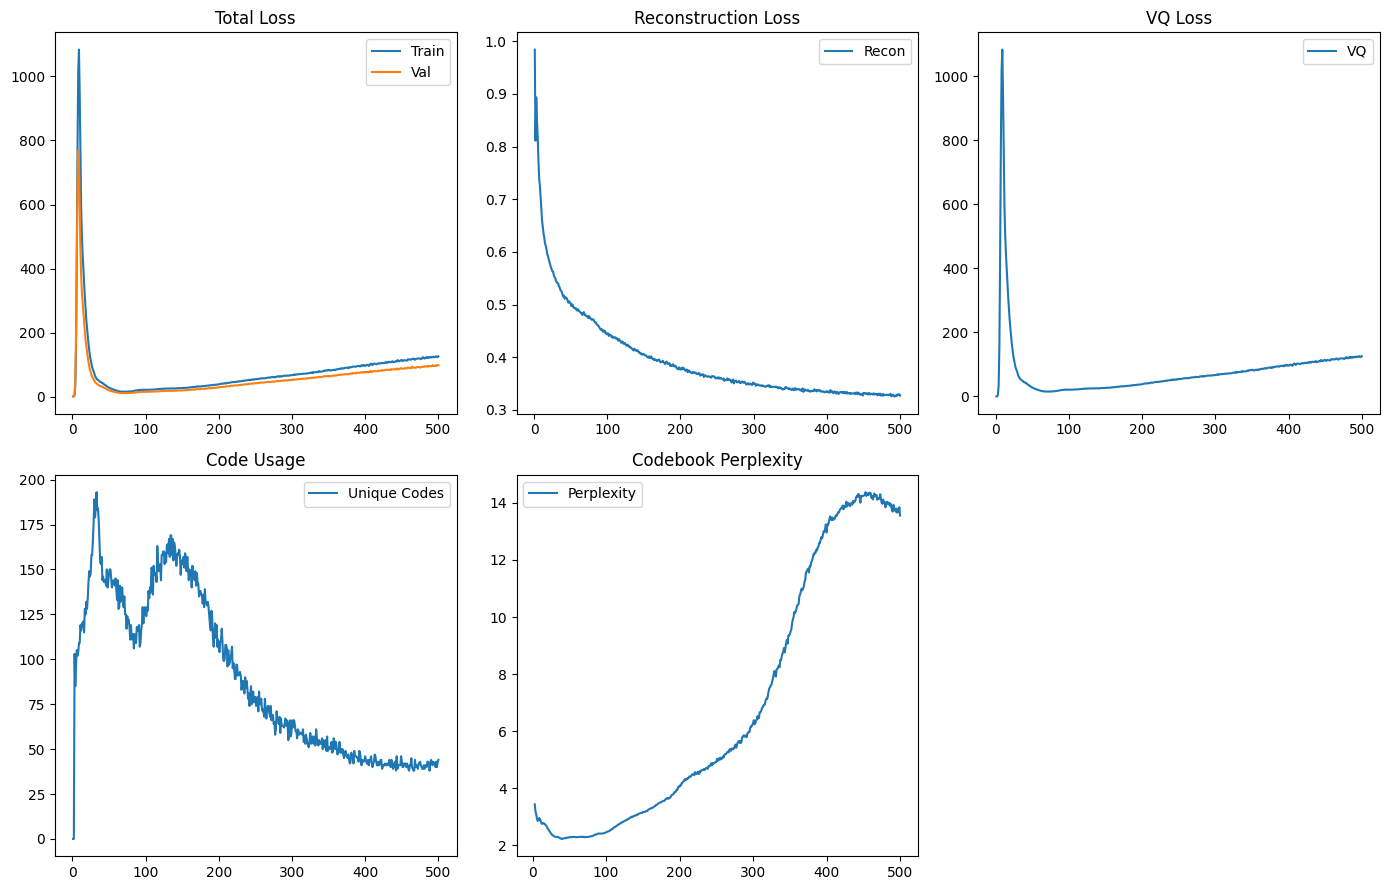

In [25]:
train_vqvae(model, train_loader, val_loader, optimizer, epochs=500)

In [26]:
os.makedirs("model pt files", exist_ok=True)
torch.save(model.state_dict(), "model pt files/vqvae_model.pth")
torch.save(model.state_dict(), "/content/drive/MyDrive/vqvae_model.pth")

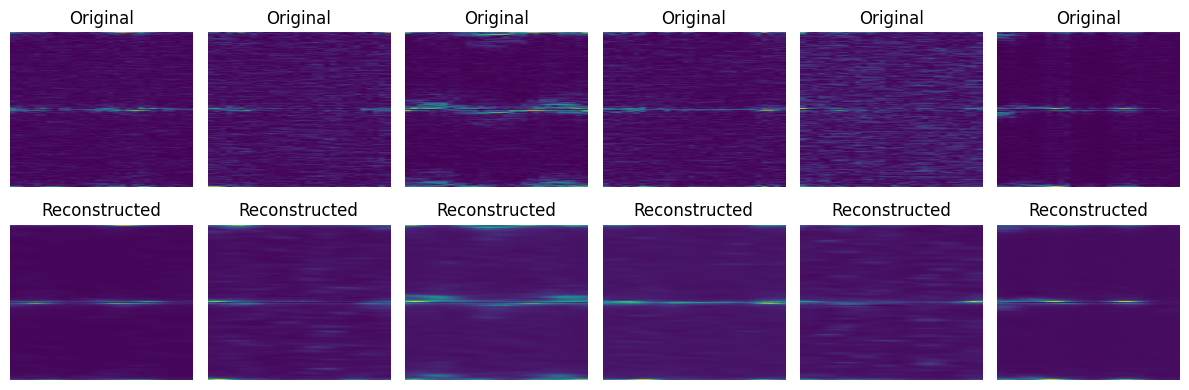

In [27]:
# Define the model again (same config as used during training)
# model = VQVAE(beta=0.75, embedding_dim=32, num_embeddings=128, decay=0.95)
model.load_state_dict(torch.load("model pt files/vqvae_model.pth"))
model.eval()
model.to(device)

# Get a batch from the validation loader
device = next(model.parameters()).device
val_iter = iter(test_loader)
batch = next(val_iter).to(device)

# Run the model
with torch.no_grad():
    output = model(batch)
    recon = output["recon_x"]

# Plot original and reconstructed images
n = min(6, batch.size(0))  # number of samples to show
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(batch[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.savefig("output_images/ReconstructionExamples.png")
plt.show()

# Average Latent Space Representation

In [28]:
def validate_chunks(chunks):
    for i, chunk in enumerate(chunks):
        if chunk['exp_no'].nunique() != 1 or chunk['activity'].nunique() != 1:
            raise ValueError(f"Chunk {i} contains multiple exp_no or activity values.")
    print("All chunks have consistent 'exp_no' and 'activity'.")

In [29]:
def sample_chunks_by_activity(chunks, n_per_activity=5, seed=2555304):
    random.seed(seed)
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)

    sampled_chunks = []
    for activity, chunk_list in activity_map.items():
        sampled = random.sample(chunk_list, min(n_per_activity, len(chunk_list)))
        sampled_chunks.extend(sampled)
    return sampled_chunks

In [30]:
def chunk_to_image(chunk, channel='PWR_ch1'):
    # Safely reshape each (200,) array to (200, 1), then stack horizontally
    images = [arr.reshape(200, 1) for arr in chunk[channel].values]
    return np.hstack(images)  # Result: (200, 80)

In [31]:
def plot_chunks_as_images(chunks, cmap='inferno'):
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)

    for activity, chunk_list in activity_map.items():
        n = len(chunk_list)
        cols = 5
        rows = int(np.ceil(n / cols))
        plt.figure(figsize=(4 * cols, 3 * rows))

        for i, chunk in enumerate(chunk_list):
            img = chunk_to_image(chunk)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img, aspect='auto', cmap=cmap, origin='lower')
            plt.title(f"{activity} #{i+1}")
            plt.axis('off')

        plt.suptitle(f"Activity: {activity}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig("output_images/Sampled Images.png")
        plt.show()


In [32]:
# Validate all chunks
validate_chunks(chunks)

All chunks have consistent 'exp_no' and 'activity'.


In [33]:
# Sample 5 chunks per activity
sampled_chunks = sample_chunks_by_activity(chunks, n_per_activity=5)

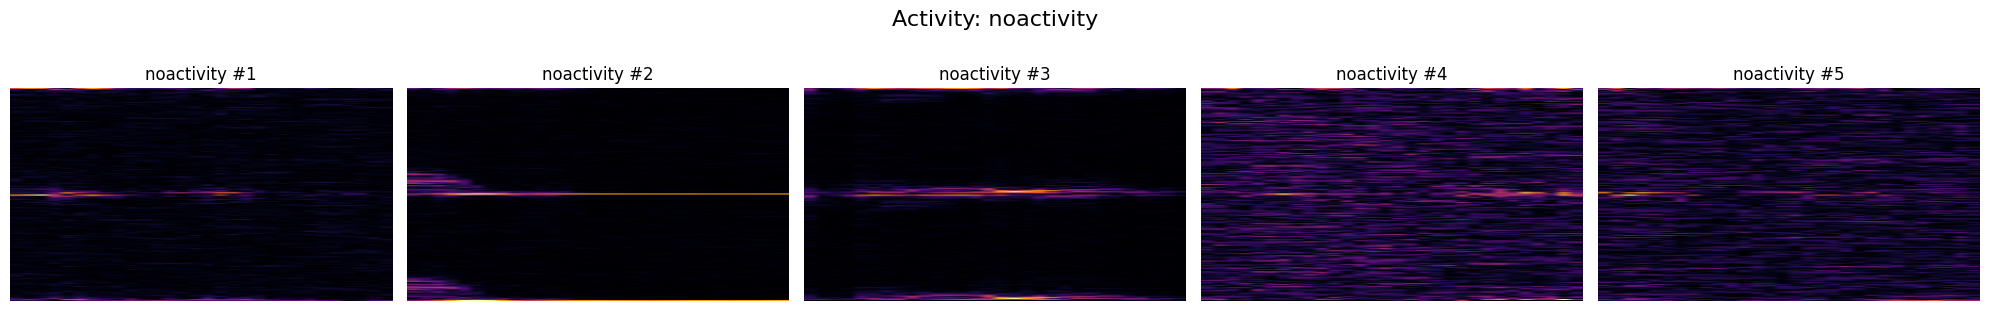

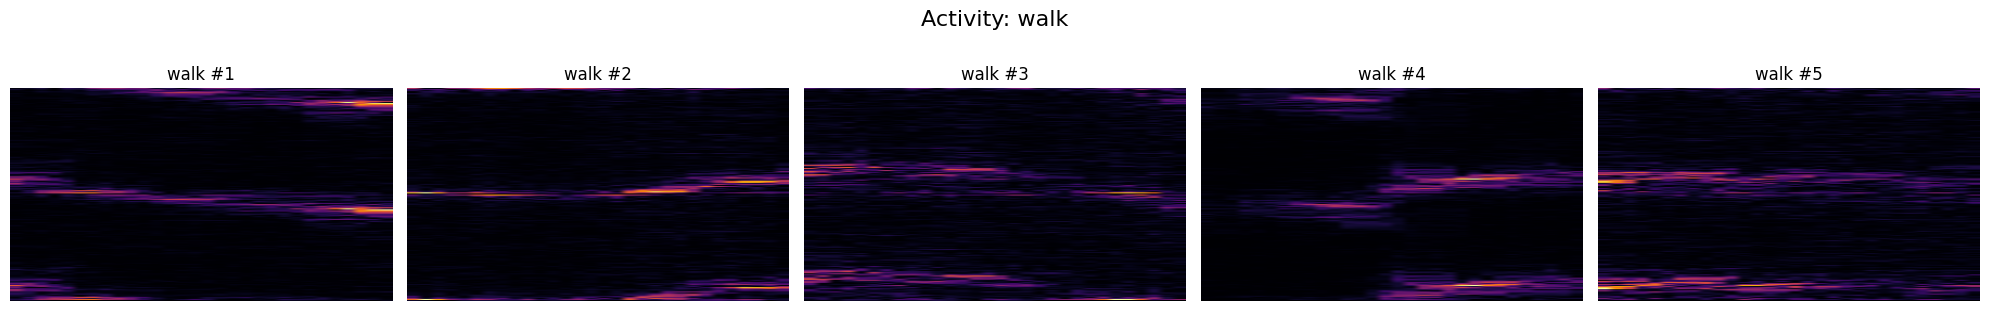

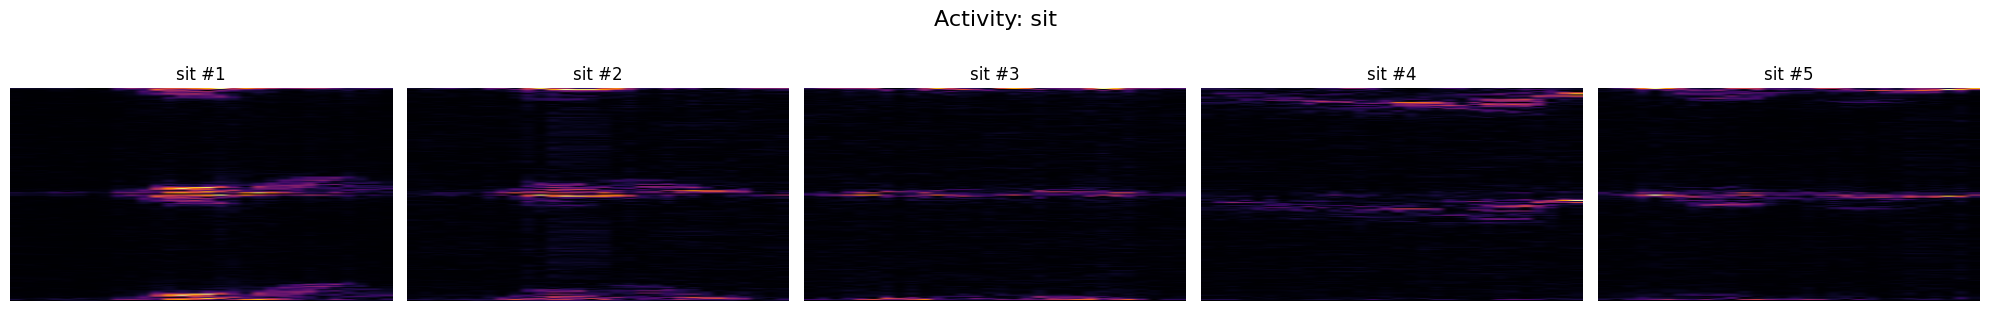

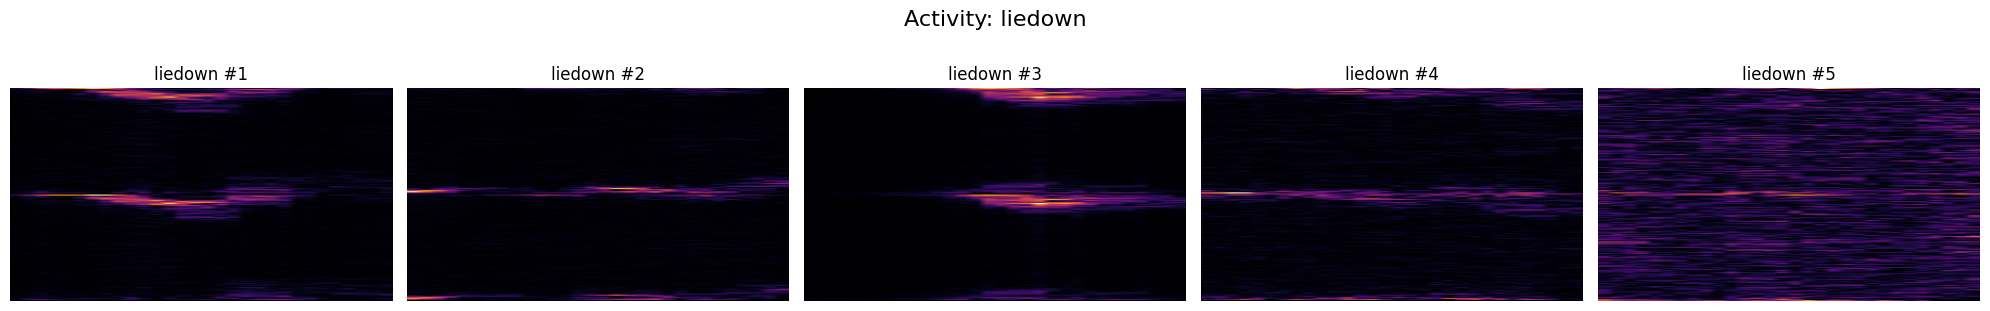

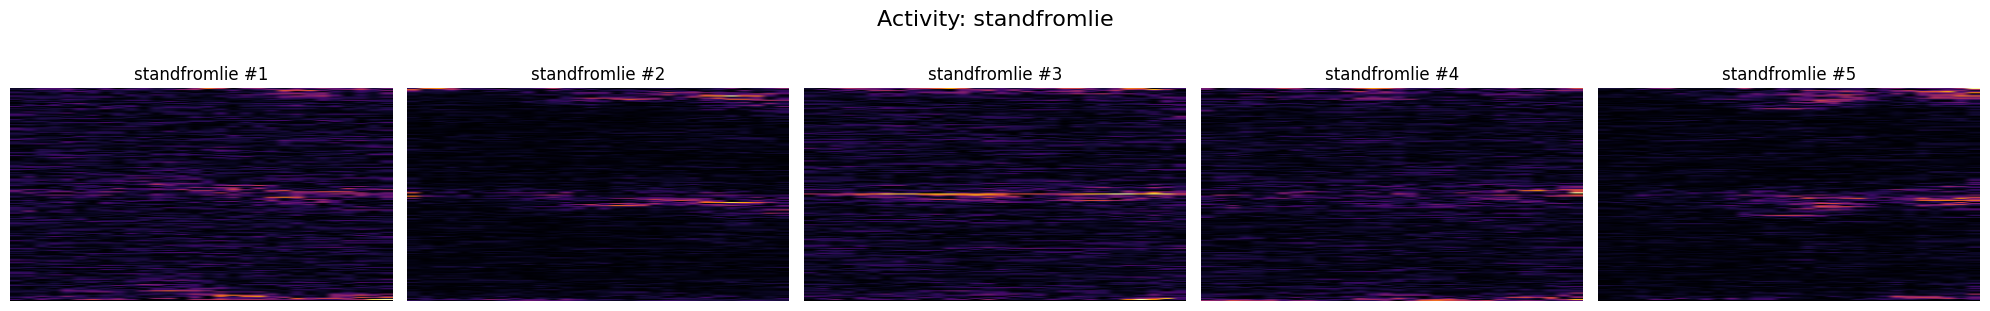

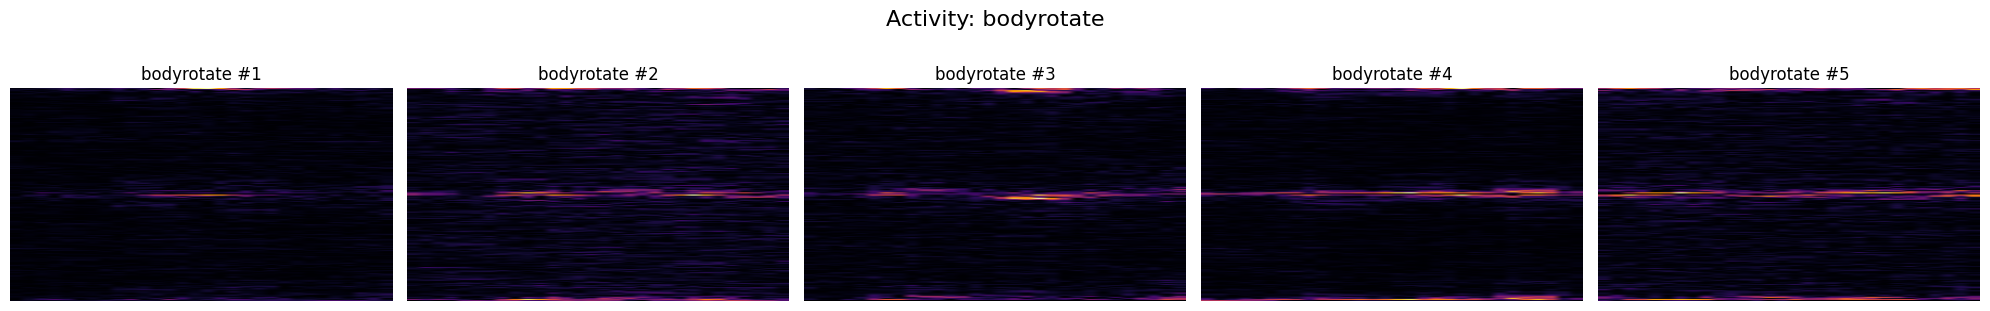

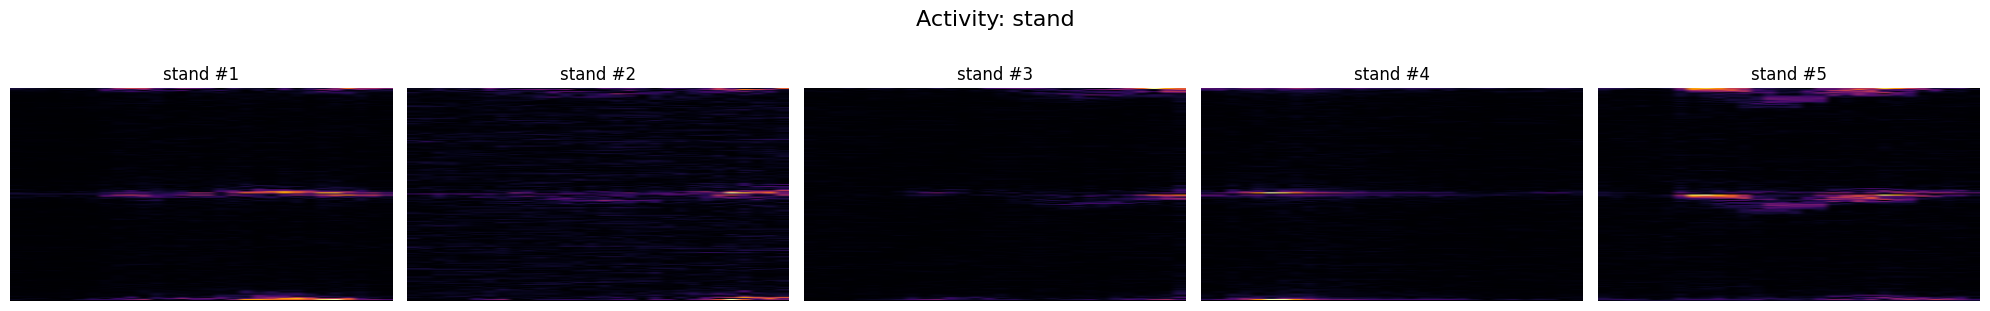

In [34]:
# Plot as images
plot_chunks_as_images(sampled_chunks)

In [35]:
def count_chunks_by_activity(chunks):
    activity_counts = Counter(chunk['activity'].iloc[0] for chunk in chunks)
    return activity_counts

In [36]:
activity_counts = count_chunks_by_activity(chunks)

for activity, count in activity_counts.items():
    print(f"{activity}: {count} chunks")

noactivity: 4048 chunks
walk: 1149 chunks
sit: 54 chunks
liedown: 194 chunks
standfromlie: 189 chunks
bodyrotate: 763 chunks
stand: 37 chunks


In [37]:
def filter_out_class(chunks, class_to_remove='noactivity'):
    return [chunk for chunk in chunks if chunk['activity'].iloc[0] != class_to_remove]

chunks = filter_out_class(chunks, class_to_remove='noactivity')

In [38]:
def encode_chunks(model, chunks, device, mode="z_q", batch_size=128):
    model.eval()
    X, y = [], []
    with torch.no_grad():
        for i in range(0, len(chunks), batch_size):
            batch = chunks[i:i+batch_size]
            imgs, labs = [], []
            for df in batch:
                labs.append(df["activity"].iat[0])
                img = np.stack(df["PWR_ch1"].to_numpy()).astype(np.float32).T[None, None, ...]
                imgs.append(img)
            xb = torch.from_numpy(np.concatenate(imgs, 0)).to(device)
            out = model(xb, quantize=(mode=="z_q"))
            z   = out["z_q"]                               # [B,C,H,W]
            m, s = z.mean((2,3)), z.std((2,3))
            z_vec = F.normalize(torch.cat([m, s], 1), p=2, dim=1)   # [B,2C]
            X.append(z_vec.cpu().numpy())
            y += labs
    return np.concatenate(X, 0), np.array(y)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr

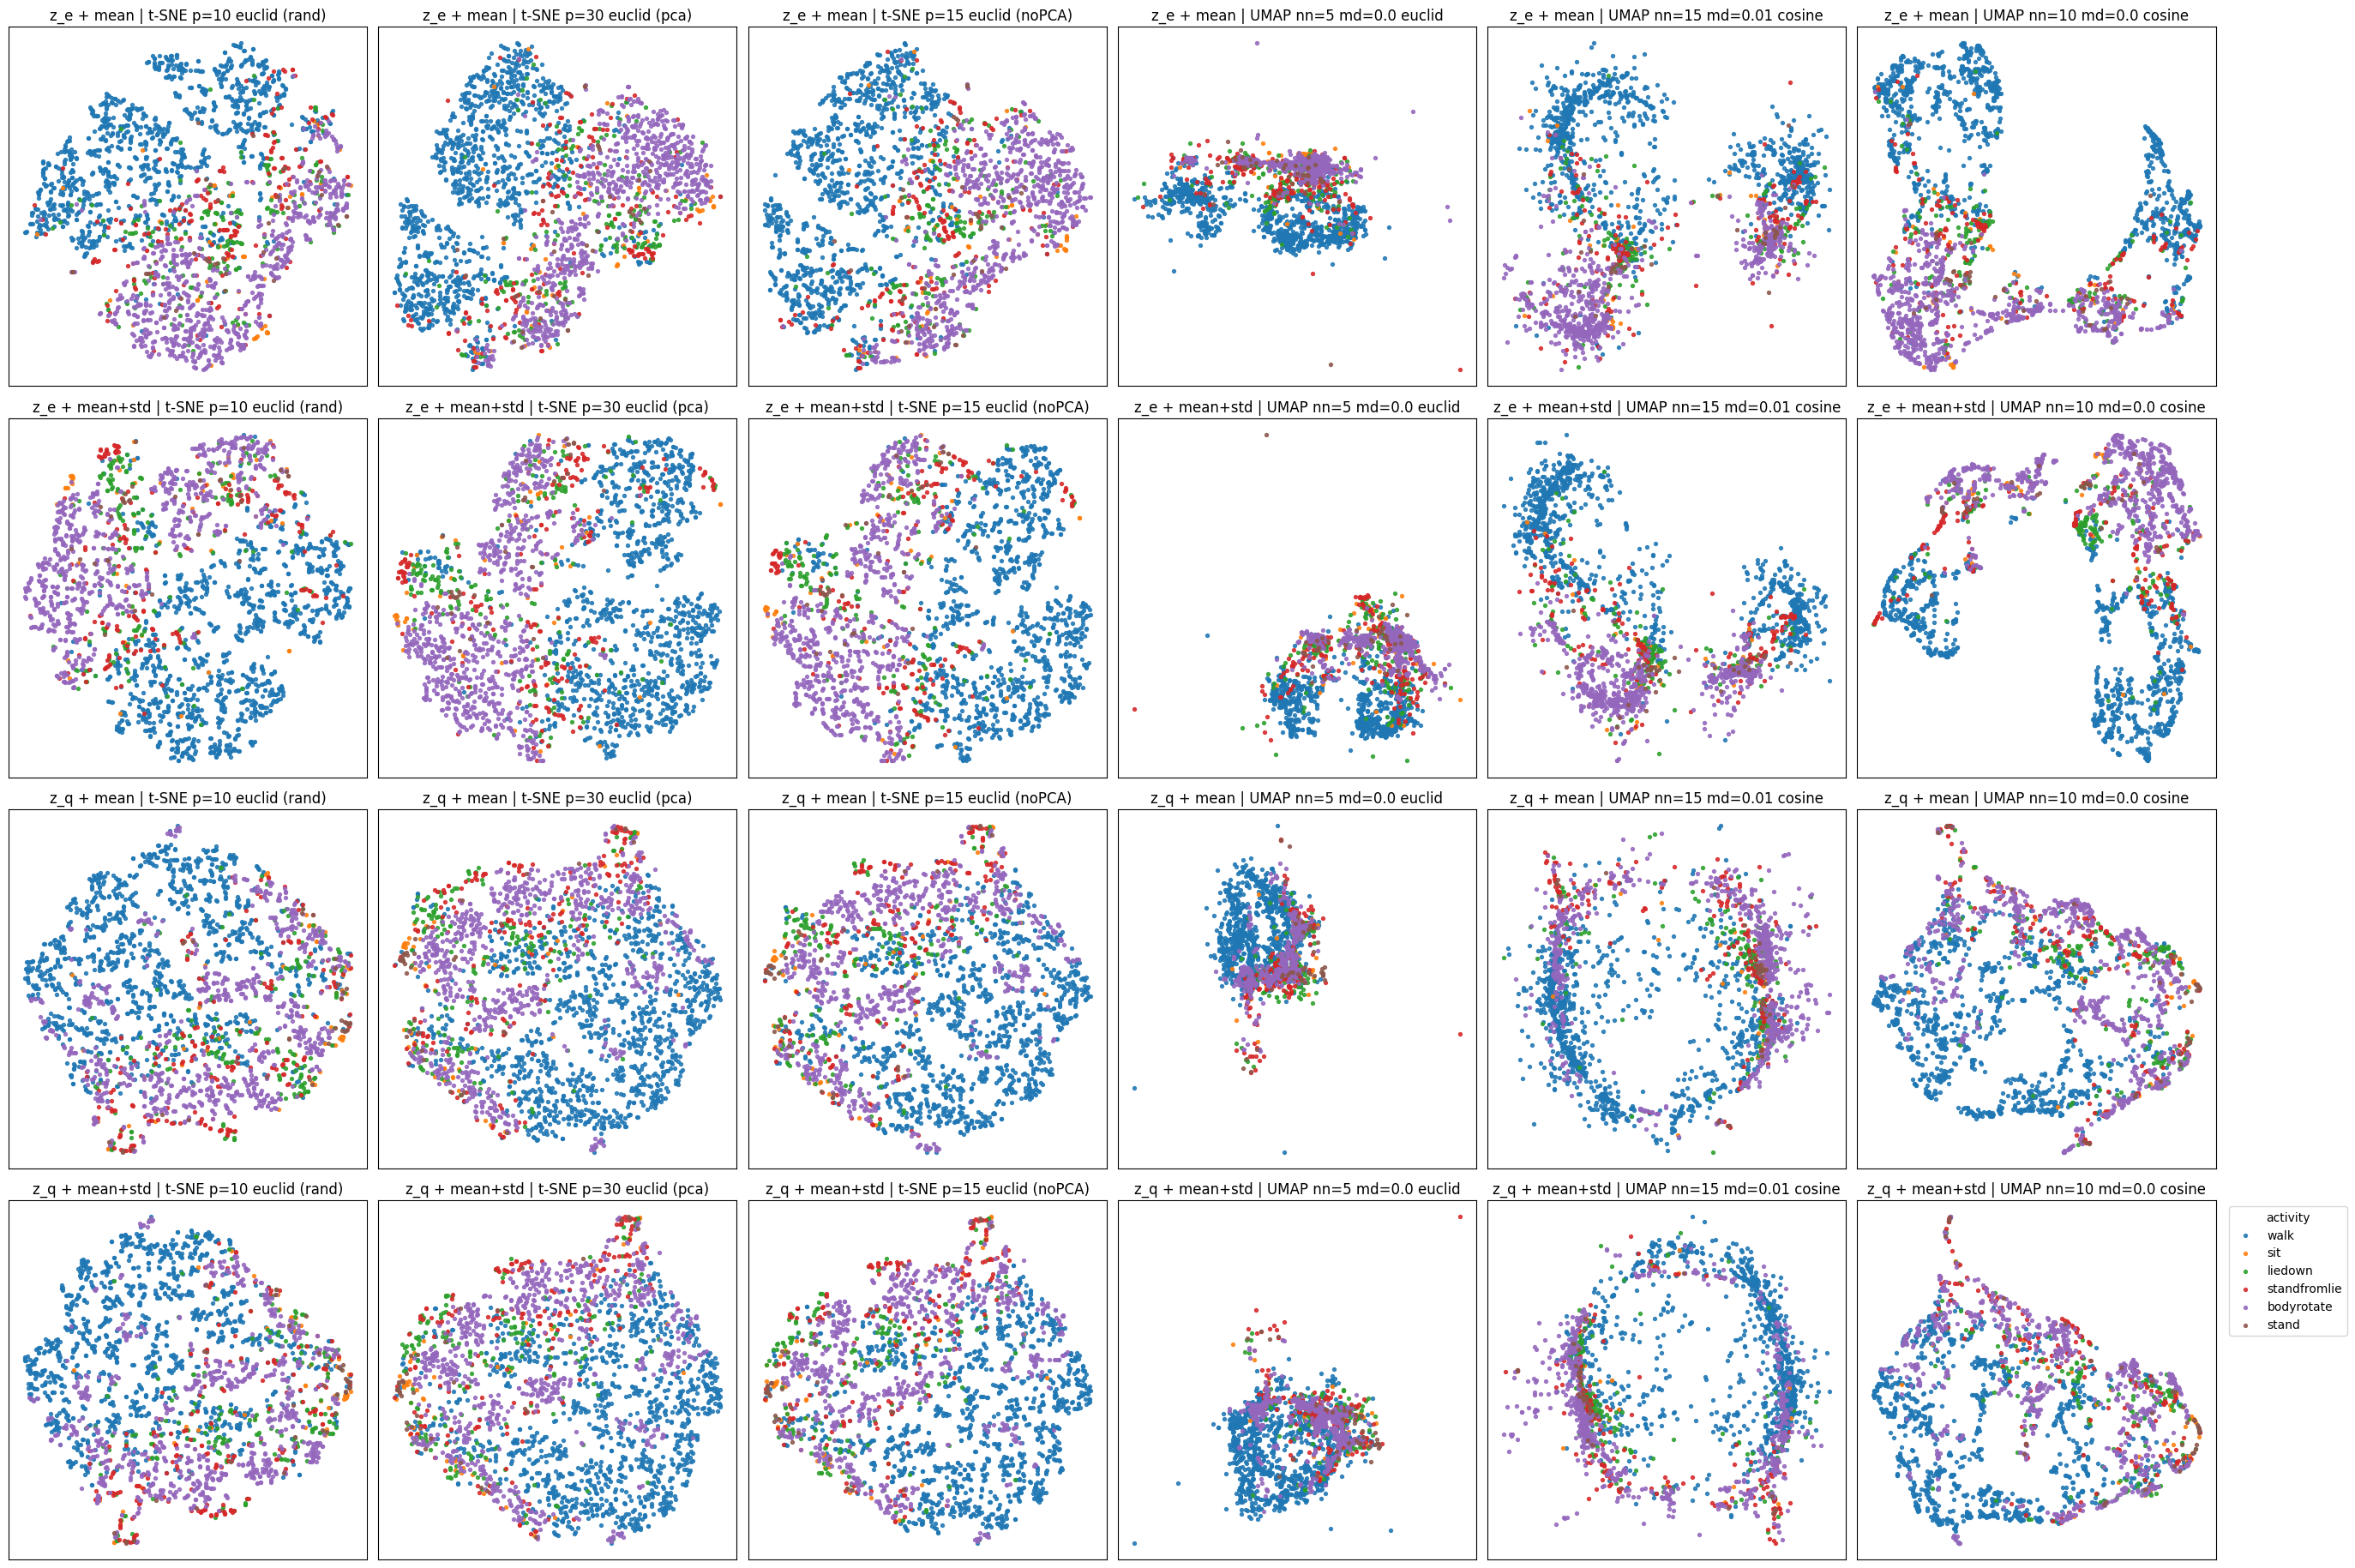

In [39]:
def infer_in_channels(model):
    # grab the first Conv2d in the encoder
    for m in model.encoder.modules():
        if isinstance(m, torch.nn.Conv2d):
            return m.in_channels
    return 1  # fallback

def df_to_tensor(df, want_C=1, pad_mode="duplicate"):
    """
    Build (C,200,T) from df columns: PWR_ch1/2/3. If missing, pad by:
      - "duplicate": repeat ch1
      - "zeros": zero channel(s)
    Per-channel z-score normalization.
    """
    # base channel
    chs = []
    ch1 = np.stack(df["PWR_ch1"].to_list(), axis=1).astype(np.float32)  # (200,T)
    chs.append(ch1)
    if want_C >= 2:
        if "PWR_ch2" in df.columns:
            chs.append(np.stack(df["PWR_ch2"].to_list(), axis=1).astype(np.float32))
        else:
            chs.append(ch1.copy() if pad_mode=="duplicate" else np.zeros_like(ch1))
    if want_C >= 3:
        if "PWR_ch3" in df.columns:
            chs.append(np.stack(df["PWR_ch3"].to_list(), axis=1).astype(np.float32))
        else:
            chs.append(ch1.copy() if pad_mode=="duplicate" else np.zeros_like(ch1))

    x = np.stack(chs, axis=0)            # (C,200,T)
    x = torch.from_numpy(x)              # float32
    # per-channel, per-sample z-score
    mean = x.mean(dim=(1,2), keepdim=True)
    std  = x.std(dim=(1,2), keepdim=True)
    std  = torch.where(std < 1e-6, torch.ones_like(std), std)
    x = (x - mean) / std
    return x

# --- Patch encode_chunks to use df_to_tensor ---
@torch.no_grad()
def encode_chunks(model, chunks, device, mode="z_q", mean_only=False, batch_size=128):
    model.eval()
    want_C = infer_in_channels(model)  # 3 for new model
    X, y = [], []
    for i in range(0, len(chunks), batch_size):
        part = chunks[i:i+batch_size]
        batch_tensors, labs = [], []
        for df in part:
            labs.append(df["activity"].iat[0])
            x = df_to_tensor(df, want_C=want_C, pad_mode="duplicate")  # (C,200,T)
            batch_tensors.append(x.unsqueeze(0))  # (1,C,200,T)
        xb = torch.cat(batch_tensors, dim=0).to(device)  # (B,C,200,T)

        if mode == "z_q":
            out = model(xb, quantize=True)
            z = out["z_q"]  # (B,C',H,W)
        else:
            ze = model.encoder(xb)
            B, D, H, W = ze.shape
            z_flat = ze.permute(0,2,3,1).reshape(-1, D)
            z = z_flat.view(B, H, W, D).permute(0,3,1,2).contiguous()

        m = z.mean((2,3))
        if mean_only:
            z_vec = F.normalize(m, p=2, dim=1)
        else:
            s = z.std((2,3))
            z_vec = F.normalize(torch.cat([m, s], dim=1), p=2, dim=1)

        X.append(z_vec.cpu().numpy()); y += labs
    return np.concatenate(X, 0), np.array(y)

def run_tsne(X, seed=2555304, **cfg):
    return TSNE(n_components=2, random_state=seed, **cfg).fit_transform(X)

def run_umap(X, seed=2555304, **cfg):
    reducer = umap.UMAP(random_state=seed, **cfg)
    return reducer.fit_transform(X)

# ---------------- configs ----------------
# columns (label, reducer_fn, use_pca, kwargs)
PANELS = [
    ("t-SNE p=10 euclid (rand)",  run_tsne, True,  dict(perplexity=10, metric="euclidean", init="random", early_exaggeration=20, learning_rate="auto")),
    ("t-SNE p=30 euclid (pca)",   run_tsne, True,  dict(perplexity=30, metric="euclidean", init="pca",    learning_rate="auto")),
    ("t-SNE p=15 euclid (noPCA)", run_tsne, False, dict(perplexity=15, metric="euclidean", init="pca",    learning_rate="auto")),
    ("UMAP nn=5 md=0.0 euclid",   run_umap, True,  dict(n_neighbors=5,  min_dist=0.0,  metric="euclidean", densmap=True)),
    ("UMAP nn=15 md=0.01 cosine", run_umap, True,  dict(n_neighbors=15, min_dist=0.01, metric="cosine",    densmap=True)),
    ("UMAP nn=10 md=0.0 cosine",  run_umap, False, dict(n_neighbors=10, min_dist=0.0,  metric="cosine",    densmap=False)),
]

# rows: (name_for_row, mode, mean_only)
ROWS = [
    ("z_e + mean",        "z_e", False),   # mean of pre-quant latents
    ("z_e + mean+std",    "z_e", True),    # (note: we’ll flip meaning below to show both)
    ("z_q + mean",        "z_q", False),   # mean of quantized latents
    ("z_q + mean+std",    "z_q", True),
]
# NB: encode_chunks(mean_only=False) = mean+std, mean_only=True = mean-only.
# Flip the booleans in ROWS if you prefer different ordering labels.

# --------------- run encodings (once per row) ---------------
# (This keeps computations reasonable even for large chunk sets.)
encodings = {}
uniq_acts = list(dict.fromkeys([df["activity"].iat[0] for df in chunks]))
for row_name, mode, is_meanstd in ROWS:
    X, lab = encode_chunks(model, chunks, device, mode=mode, mean_only=is_meanstd, batch_size=128)
    encodings[row_name] = (X, lab)

# consistent colors
labels_all = next(iter(encodings.values()))[1]
uniq = list(dict.fromkeys(labels_all))
act2idx = {a:i for i,a in enumerate(uniq)}

# --------------- plotting grid ---------------
cols = len(PANELS)
rows = len(ROWS)
plt.figure(figsize=(5.2*cols, 4.6*rows))

for r, (row_name, _, _) in enumerate(ROWS):
    X, labels = encodings[row_name]
    # PCA (shared per-row so panels are comparable)
    n_pca = min(100, X.shape[1])
    X_pca = PCA(n_components=n_pca, random_state=2555304).fit_transform(X)

    for c, (title, fn, use_pca, cfg) in enumerate(PANELS):
        plt.subplot(rows, cols, r*cols + c + 1)
        X_in = X_pca if use_pca else X
        emb = fn(X_in, **cfg)

        for a in uniq:
            mask = (labels == a)
            plt.scatter(emb[mask,0], emb[mask,1], s=8, alpha=0.85, label=a)
        plt.title(f"{row_name} | {title}")
        plt.xticks([]); plt.yticks([])

# single shared legend
handles, labs = plt.gca().get_legend_handles_labels()
dedup = dict(zip(labs, handles))
plt.legend(dedup.values(), dedup.keys(), title="activity",
           bbox_to_anchor=(1.02, 1.0), loc="upper left", frameon=True)

plt.tight_layout()
plt.subplots_adjust(right=0.83)
plt.savefig("/content/drive/MyDrive/latent_grid_ze_zq_pooling.png", dpi=220)
plt.savefig("output_images/latent_grid_ze_zq_pooling.png", dpi=220)
plt.show()

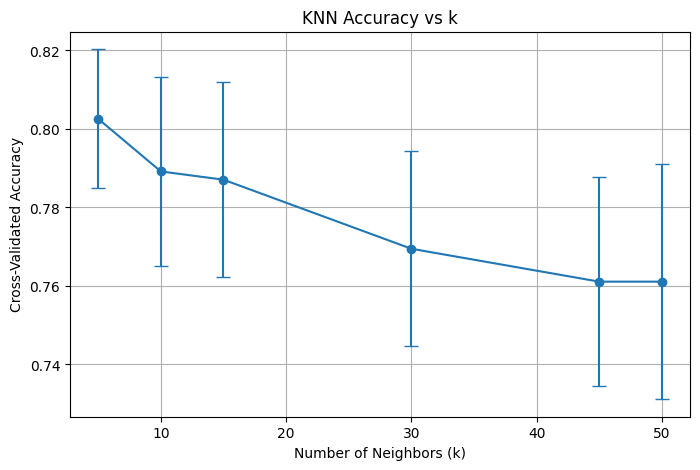

k= 5 | Mean Acc = 0.8026 ± 0.0177
k=10 | Mean Acc = 0.7892 ± 0.0240
k=15 | Mean Acc = 0.7871 ± 0.0248
k=30 | Mean Acc = 0.7695 ± 0.0248
k=45 | Mean Acc = 0.7611 ± 0.0267
k=50 | Mean Acc = 0.7611 ± 0.0300


In [40]:
# --- Inputs ---
X = np.array(X)       # feature matrix from VQVAE
y = np.array(lab)     # class labels
groups = None         # replace with np.array(subject_ids) if grouping by subject
k_list = [5, 10, 15, 30, 45, 50]

# --- CV strategy ---
if groups is not None:
    cv_strategy = GroupKFold(n_splits=5).split(X, y, groups)
else:
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Loop over k values ---
scores_mean = []
scores_std = []

for k in k_list:
    knn_pipe = make_pipeline(
        StandardScaler(),
        Normalizer(),
        KNeighborsClassifier(n_neighbors=k, metric='cosine')
    )
    scores = cross_val_score(knn_pipe, X, y, cv=cv_strategy)
    scores_mean.append(scores.mean())
    scores_std.append(scores.std())

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.errorbar(k_list, scores_mean, yerr=scores_std, fmt='-o', capsize=5)
plt.title("KNN Accuracy vs k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

# --- Print table for reference ---
for k, m, s in zip(k_list, scores_mean, scores_std):
    print(f"k={k:>2} | Mean Acc = {m:.4f} ± {s:.4f}")

# KNN

In [41]:
model.load_state_dict(torch.load("model pt files/vqvae_model.pth"))

<All keys matched successfully>

In [42]:
def extract_code_hists(model, loader, K, device="cuda", hellinger=True):
    model.eval()
    X, y = [], []
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                xb, yb = batch
                y.append(yb.cpu().numpy())
            else:
                xb, yb = batch, None
            xb = xb.to(device)
            idx = model(xb, quantize=True)["indices"].view(xb.size(0), -1)  # [B, H*W]
            for i in range(idx.size(0)):
                h = torch.bincount(idx[i], minlength=K).float()
                h = h / (h.sum() + 1e-8)
                if hellinger:
                    h = torch.sqrt(h); h = h / (h.norm() + 1e-8)
                X.append(h.cpu().numpy())
    X = np.stack(X).astype(np.float32)
    y = None if not y else np.concatenate(y)
    return X, y

In [43]:
class WithLabels(Dataset):
    """
    Wrap any dataset that returns x (or (x, _)) and attach your own labels.
    Ensures __getitem__ returns (x, y).
    """
    def __init__(self, base_ds: Dataset, labels):
        self.base = base_ds
        self.labels = np.asarray(labels)
        assert len(self.base) == len(self.labels), "labels length must match dataset"

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        item = self.base[i]
        x = item[0] if isinstance(item, (tuple, list)) else item
        y = self.labels[i]
        if not torch.is_tensor(y):
            # try to make a LongTensor; if it's non-numeric, leave as-is
            try:
                y = torch.tensor(int(y), dtype=torch.long)
            except Exception:
                y = torch.tensor(y) if isinstance(y, (np.ndarray, list)) else y
        return x, y

In [44]:
from sklearn.preprocessing import LabelEncoder

# assume chunks_train / chunks_val are lists of dataframes
y_train_raw = [df["activity"].iloc[0] for df in train_chunks]  # one label per chunk
y_val_raw   = [df["activity"].iloc[0] for df in val_chunks]

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_val   = le.transform(y_val_raw)

train_ds = ChunkImageDataset(train_chunks, in_channels=3)
val_ds   = ChunkImageDataset(val_chunks,   in_channels=3)

train_ds = WithLabels(train_ds, y_train)
val_ds   = WithLabels(val_ds,   y_val)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[0 2 2 ... 2 1 2]


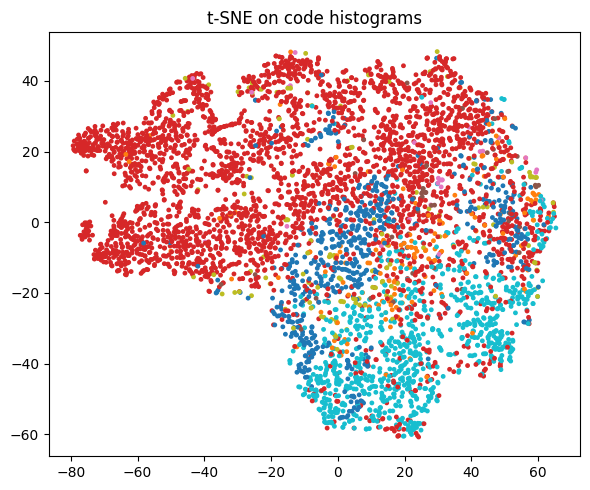

In [45]:
K = model.quantizer.num_embeddings
X, y = extract_code_hists(model, train_loader, K, device=device)  # returns X [N,K], y [N] or None

print(y)

# Encode non-numeric labels if needed
if y is not None and y.dtype.kind not in "iu":   # not int/uint
    le = LabelEncoder(); y_plot = le.fit_transform(y)
else:
    y_plot = y

# Reduce to 2D and plot with label colors
X50 = PCA(n_components=min(50, X.shape[1]-1)).fit_transform(X)
X2  = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30).fit_transform(X50)

plt.figure(figsize=(6,5))
if y_plot is None:
    plt.scatter(X2[:,0], X2[:,1], s=6)
else:
    sc = plt.scatter(X2[:,0], X2[:,1], c=y_plot, s=6, cmap="tab10")
plt.title("t-SNE on code histograms"); plt.tight_layout(); plt.show()